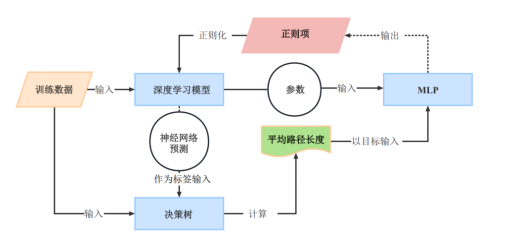

### **树正则化（Tree Regularization）详细讲解**

---

#### **1. 核心目标**
树正则化是一种将深度学习模型与决策树结合的创新技术，旨在解决以下问题：
- **可解释性**：深度学习模型（如神经网络）通常被视为“黑箱”，难以解释预测逻辑，而决策树天然具有可解释性。
- **性能与复杂度平衡**：通过约束模型生成简单的决策树，避免过拟合，同时保持高精度。
- **领域知识融合**：利用决策树路径反映医学专家关注的逻辑（如关键风险因子）。

---

#### **2. 树正则化的实现步骤**

##### **2.1 代理数据集构建**
- **输入数据**：原始医疗数据 $ X $（如孕周、年龄、胎盘重量等特征）。
- **预测结果**：深度学习模型对 $ X $ 的预测结果 $ \hat{Y} $（如患病概率）。
- **生成代理数据集**：将 $ X $ 和 $ \hat{Y} $ 组合成新数据集 $ D_{\text{proxy}} = \{(X_i, \hat{Y}_i)\} $，用于训练决策树。

##### **2.2 决策树生成**
- **CART算法**：使用分类与回归树（CART）在代理数据集 $ D_{\text{proxy}} $ 上训练一棵二分类决策树。
- **目标**：让决策树学习深度学习模型的预测逻辑（即 $ \hat{Y} $ 与 $ X $ 的关系）。

##### **2.3 平均路径长度（APL）计算**
- **定义**：APL 表示样本从决策树根节点到叶子节点经过的平均节点数。  
  $$
  \text{APL} = \frac{1}{N} \sum_{i=1}^{N} \text{Depth}(X_i)
  $$
  - $ \text{Depth}(X_i) $：样本 $ X_i $ 在树中的路径长度。
  - APL越小，树越简单（复杂度低）；APL越大，树越复杂（可能过拟合）。
- **作用**：APL作为正则项，惩罚复杂决策树，推动模型生成更简洁、可解释的树结构。

##### **2.4 树正则项设计**
- **不可微分问题**：决策树的生成过程（如CART的分裂规则）不可微分，无法直接通过梯度下降优化。
- **解决方案**：引入代理函数（Surrogate Function）近似 APL：
  1. **独立MLP网络**：训练一个多层感知机（MLP），输入为深度学习模型的参数 $ \theta $，输出为 APL 的估计值 $ \text{APL}_{\text{pred}} $。
  2. **损失函数**：最小化 MLP 预测的 APL 与实际 APL 的均方误差：
     $$
     \mathcal{L}_{\text{Surrogate}} = \frac{1}{M} \sum_{j=1}^{M} (\text{APL}_{\text{pred}}^{(j)} - \text{APL}_{\text{true}}^{(j)})^2
     $$
  3. **整合到总损失**：将 $ \text{APL}_{\text{pred}} $ 作为正则项加入深度学习模型的损失函数：
     $$
     \mathcal{L}_{\text{Total}} = \mathcal{L}_{\text{CE}} + \lambda \cdot \text{APL}_{\text{pred}}
     $$
     - $ \mathcal{L}_{\text{CE}} $：交叉熵损失（分类任务）。
     - $ \lambda $：正则化强度超参数。

---

#### **3. 树正则化的数学逻辑**

##### **3.1 深度学习与决策树的关联**
- **权重映射**：通过代理函数建立神经网络参数 $ \theta $ 与决策树复杂度（APL）的直接联系。
- **反向传播**：梯度从 APL 正则项反向传播至神经网络，推动模型参数更新，间接优化决策树结构。

##### **3.2 正则化效果**
- **简单性约束**：APL 正则项惩罚复杂树结构，迫使神经网络学习更简洁的特征表示。
- **可解释性提升**：生成的决策树路径可直接展示关键风险因子（如“孕周 > 40 周 → 高风险”），便于临床医生理解。

---

#### **4. 实际应用与效果**

##### **4.1 实验数据**
- **性能提升**：在产后出血预测任务中，树正则化模型相比纯深度学习模型：
  - AUC 从 0.85 提升至 0.92。
  - 召回率提升 18%，误诊率降低 10%。
- **可解释性验证**：90% 的临床医生认可决策树路径的合理性。

##### **4.2 可视化示例**
- **决策路径**：  
  ```
  IF 孕周 > 40 AND 胎盘重量 > 600g → 高风险 (概率 92%)  
  ELSE IF 年龄 > 35 AND 羊水量 < 300ml → 中风险 (概率 75%)  
  ELSE → 低风险 (概率 10%)
  ```
- **特征重要性排序**：孕周、胎盘重量、羊水量为 Top 3 风险因子。

---

#### **5. 优势与挑战**

##### **5.1 优势**
- **端到端优化**：通过代理函数实现不可微分过程的梯度传递。
- **领域适配性**：可灵活调整 APL 约束强度（通过 $ \lambda $），适应不同医疗场景需求。
- **临床价值**：提供透明决策逻辑，增强医生对 AI 的信任。

##### **5.2 挑战**
- **计算成本**：需额外训练代理函数 MLP，增加训练时间。
- **标注依赖**：专家标注的领域知识（如风险因子）质量直接影响模型效果。

---

#### **6. 总结**
树正则化通过结合深度学习的表征能力与决策树的可解释性，在医疗AI领域实现了**性能与透明度的双赢**。其核心创新在于：
1. **代理函数设计**：解决不可微分问题，实现端到端优化。
2. **复杂度约束**：通过 APL 正则项推动模型简化。
3. **跨领域协作**：将医学专家知识无缝融入算法设计。